In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1662
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1662
┌ Info: Precompiling Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
└ @ Base loading.jl:1662
┌ Info: Precompiling SparseIR [4fe2279e-80f0-4adb-8463-ee114ff56b7d]
└ @ Base loading.jl:1662
┌ Info: Precompiling Nevanlinna [0b21cfa8-e591-48a4-a07b-a9d20be7c264]
└ @ Base loading.jl:1662


In [2]:
T = BigFloat

BigFloat

In [3]:
beta::Float64 = 100
wmax::Float64 = 10
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 100.0, ωmax = 10.0

In [4]:
include("../flex_src/IRFLEX.jl")

┌ Info: Precompiling FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341]
└ @ Base loading.jl:1662
┌ Info: Precompiling OMEinsum [ebe7aa44-baf0-506c-a96f-8464559b3922]
└ @ Base loading.jl:1662


Main.IRFLEX

In [5]:
nsize::Int64 = 1024
t_pra::Float64 = 0.0
filling::Float64 = 1.0
U = 0.5
hami = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [6]:
ratio_U = 0.0
precision = 1e-4
loose_precision = 1e+3*precision
gkf0 = IRFLEX.make_free_giw(lat, basis)
;

In [7]:
# Compute chi0
chi0kf = IRFLEX.calc_chi0(gkf0, lat, basis)

# Compute chi
chiskf = chi0kf ./ (1.0 .- lat.U*chi0kf)
;

In [8]:
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

36

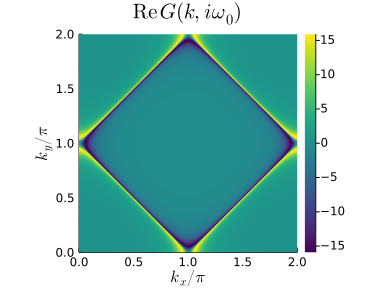

In [9]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(gkf0[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

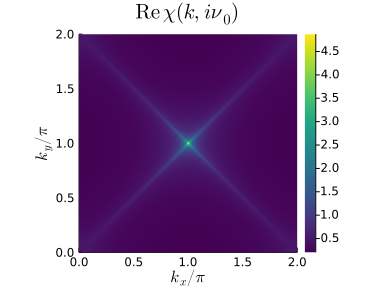

In [10]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(chiskf[hnw+1,:,:]),
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"),
    c=:viridis,
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [11]:
#smpl_wn_b = SparseIR.default_matsubara_sampling_points(basis.basis_b)
#smpl_wn_b = smpl_wn_b[smpl_wn_b .!= BosonicFreq(0)]
#smpl_wn_b_wo_zero = MatsubaraSampling(basis.basis_b, smpl_wn_b)
;

In [12]:
chisf = chi0kf[:,nsize÷2+1, nsize÷2+1]
#deleteat!(chisf, hnw+1)
#chisl = fit(smpl_wn_b_wo_zero, chisf, dim=1)
#chisf[37] = 0
chisl = fit(basis.smpl_wn_b, chisf, dim=1)
;

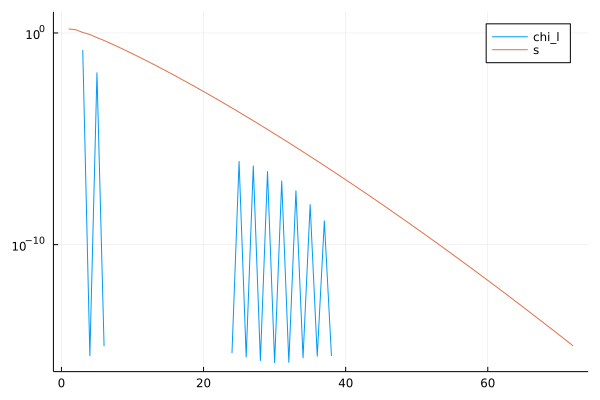

In [13]:
plot(yaxis=:log,ylims=(1e-16,10))
#plot()
plot!(real.(chisl),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

In [14]:
#smpl_wn_b_dense = MatsubaraSampling(basis.basis_b, SparseIR.BosonicFreq.(collect(-2332:2:2332)))
#chisl_d = fit(basis.smpl_wn_b, chisf)
#chisf_d = evaluate(smpl_wn_b_dense, chisl_d)
#deleteat!(chisf_d, 1167)
#chisf_d[1167]=0.0
#chisl_d = fit(smpl_wn_b_dense, chisf_d)
;

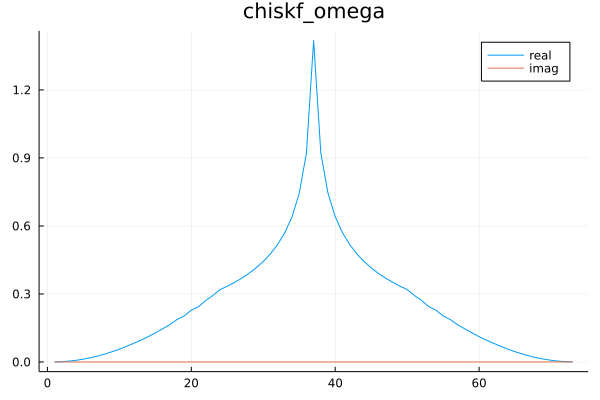

In [15]:
plot(title="chiskf_omega")
plot!(real.(chisf), label="real")
plot!(imag.(chisf), label="imag")

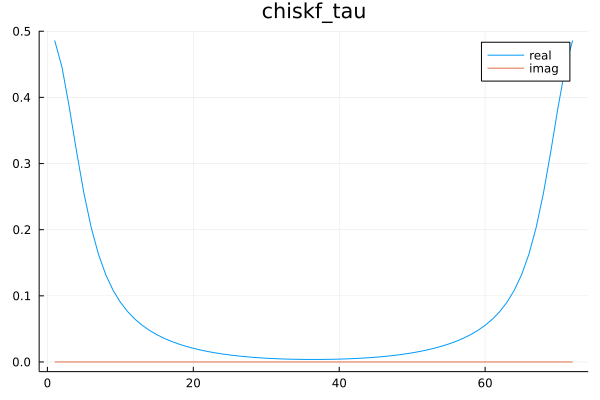

In [16]:
chist = evaluate(basis.smpl_tau_b, chisl)
plot(title="chiskf_tau")
plot!(real.(chist[:]), label="real")
plot!(imag.(chist[:]), label="imag")

In [17]:
chisw = evaluate(basis.smpl_wn_f, chisl)
;

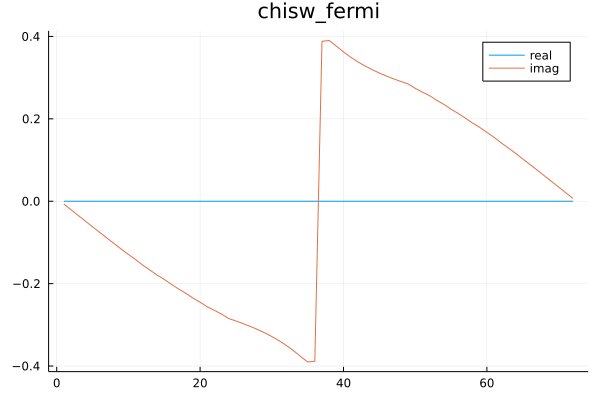

In [18]:
plot(title="chisw_fermi")
plot!(real.(chisw[:]), label="real")
plot!(imag.(chisw[:]), label="imag")

In [19]:
sum = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl))

0.9923974424667033

In [20]:
setprecision(512)

512

In [21]:
input_chi  = Array{Complex{T}}(undef, hnw) 
input_smpl = Array{Complex{T}}(undef, hnw) 
;

In [22]:
for i in 1:hnw
    input_smpl[i] = SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(basis))
    input_chi[i]  = -chisw[hnw+i]
end

In [52]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, input_smpl, input_chi)
#N_imag = hnw 
println("N_imag $(N_imag)")

N_imag is setted as 35
N_imag 35


In [43]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     1.434988e+00     2.856592e-01
 * time: 5.1021575927734375e-5
     1     1.385730e+00     1.774399e-01
 * time: 0.2530221939086914
     2     1.357638e+00     3.647493e-02
 * time: 1.0266261100769043
     3     1.352596e+00     1.136131e-02
 * time: 1.2284300327301025
     4     1.352506e+00     5.593211e-03
 * time: 1.365239143371582
     5     1.352488e+00     4.668161e-04
 * time: 1.5005571842193604
     6     1.352488e+00     2.573830e-04
 * time: 1.7027180194854736
     7     1.352488e+00     8.531363e-05
 * time: 1.9055101871490479
     8     1.352488e+00     2.977438e-05
 * time: 2.085045099258423
     9     1.352488e+00     8.688532e-06
 * time: 2.64447021484375
    10     1.352488e+00     6.701007e-06
 * time: 2.77994704246521
    11     1.352488e+00     1.478113e-06
 * time: 2.9144442081451416
    12     1.352488e+00     8.274188e-07
 * time: 3.049262046813965
    13     1.352488e+00

In [44]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     1.352488e+00     7.479016e-09
 * time: 0.00017499923706054688
max_theta=0.295842051603145339173370196579944211026652338188428071679165517672803644423818709511100204466450218975423300724827342160882952659229838498318080215660565981
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     1.352488e+00     3.108774e-01
 * time: 5.793571472167969e-5
     1     1.277002e+00     2.588149e-01
 * time: 0.15413594245910645
     2     1.178606e+00     8.981532e-02
 * time: 0.382066011428833
     3     1.173163e+00     7.869574e-02
 * time: 0.533315896987915
     4     1.165302e+00     5.646639e-02
 * time: 0.6898560523986816
     5     1.160542e+00     2.375125e-02
 * time: 0.8692748546600342
     6     1.159579e+00     1.804128e-02
 * time: 1.0283520221710205
     7     1.159012e+00     1.058341e-02
 * time: 1.3333818912506104
     8     1.158950e+00     6.936252e-03
 * time: 1.733867883682251
     9     1.15

    19     6.780219e-01     2.432503e-03
 * time: 4.770832061767578
    20     6.780169e-01     2.272387e-03
 * time: 5.022505044937134
    21     6.780128e-01     1.829150e-03
 * time: 5.448654890060425
    22     6.780091e-01     1.829402e-03
 * time: 5.646272897720337
    23     6.780063e-01     1.406279e-03
 * time: 5.8609349727630615
    24     6.780039e-01     1.536529e-03
 * time: 6.0498740673065186
    25     6.780022e-01     1.072376e-03
 * time: 6.238058090209961
    26     6.780011e-01     9.942497e-04
 * time: 6.4272119998931885
    27     6.780004e-01     6.322254e-04
 * time: 6.668659925460815
    28     6.780000e-01     5.280765e-04
 * time: 7.143449068069458
    29     6.779997e-01     3.762831e-04
 * time: 7.3342061042785645
    30     6.779996e-01     3.687090e-04
 * time: 7.526134014129639
    31     6.779994e-01     3.410704e-04
 * time: 7.733997106552124
    32     6.779993e-01     3.343126e-04
 * time: 7.932374000549316
    33     6.779992e-01     2.916406e-04
 * 

    34     4.542126e-01     1.094138e-04
 * time: 9.754524946212769
    35     4.542125e-01     1.027162e-04
 * time: 9.962523937225342
    36     4.542125e-01     1.098611e-04
 * time: 10.174284934997559
    37     4.542125e-01     7.661427e-05
 * time: 10.424657821655273
    38     4.542125e-01     8.936741e-05
 * time: 10.698323011398315
    39     4.542125e-01     6.758614e-05
 * time: 11.16838002204895
    40     4.542125e-01     8.206456e-05
 * time: 11.37769103050232
    41     4.542125e-01     5.345783e-05
 * time: 11.58573293685913
    42     4.542125e-01     6.478789e-05
 * time: 11.793485879898071
    43     4.542125e-01     4.276361e-05
 * time: 12.001747846603394
    44     4.542125e-01     4.669154e-05
 * time: 12.22977900505066
    45     4.542125e-01     3.039301e-05
 * time: 12.50416898727417
    46     4.542125e-01     3.423556e-05
 * time: 13.004467010498047
    47     4.542125e-01     2.529742e-05
 * time: 13.21456789970398
    48     4.542125e-01     2.633570e-05
 

    37     2.742483e-01     7.190082e-04
 * time: 11.007765054702759
    38     2.742472e-01     8.949101e-04
 * time: 11.622030973434448
    39     2.742464e-01     5.188057e-04
 * time: 11.851271152496338
    40     2.742459e-01     5.981135e-04
 * time: 12.19274115562439
    41     2.742455e-01     4.843312e-04
 * time: 12.420921087265015
    42     2.742453e-01     5.178279e-04
 * time: 12.66461992263794
    43     2.742451e-01     3.693695e-04
 * time: 12.971439123153687
    44     2.742449e-01     4.549295e-04
 * time: 13.474900007247925
    45     2.742448e-01     2.784895e-04
 * time: 13.703352928161621
    46     2.742447e-01     4.081860e-04
 * time: 13.932263135910034
    47     2.742446e-01     2.677374e-04
 * time: 14.16014313697815
    48     2.742445e-01     3.430587e-04
 * time: 14.387201070785522
    49     2.742444e-01     2.300799e-04
 * time: 14.628031969070435
    50     2.742443e-01     2.769120e-04
 * time: 14.929145097732544
    51     2.742443e-01     1.734940e

   157     2.742439e-01     2.777533e-08
 * time: 45.205950021743774
   158     2.742439e-01     2.984114e-08
 * time: 45.435094118118286
   159     2.742439e-01     2.388977e-08
 * time: 45.662166118621826
   160     2.742439e-01     2.600623e-08
 * time: 45.8891339302063
   161     2.742439e-01     2.024003e-08
 * time: 46.13981294631958
   162     2.742439e-01     2.231378e-08
 * time: 46.43777108192444
   163     2.742439e-01     1.779840e-08
 * time: 46.941203117370605
   164     2.742439e-01     1.892701e-08
 * time: 47.16975402832031
   165     2.742439e-01     1.582596e-08
 * time: 47.39854598045349
   166     2.742439e-01     1.592557e-08
 * time: 47.62625503540039
   167     2.742439e-01     1.381596e-08
 * time: 47.85308313369751
   168     2.742439e-01     1.328236e-08
 * time: 48.0954909324646
   169     2.742439e-01     1.172939e-08
 * time: 48.400567054748535
   170     2.742439e-01     1.094209e-08
 * time: 48.93199110031128
   171     2.742439e-01     9.629224e-09
 * t

   102     1.461582e-01     3.537699e-07
 * time: 36.36637592315674
   103     1.461582e-01     5.090784e-07
 * time: 36.73729109764099
   104     1.461582e-01     2.989337e-07
 * time: 37.01427602767944
   105     1.461582e-01     3.544997e-07
 * time: 37.7191379070282
   106     1.461582e-01     2.121749e-07
 * time: 37.969401121139526
   107     1.461582e-01     2.979422e-07
 * time: 38.36276912689209
   108     1.461582e-01     1.879967e-07
 * time: 38.610471963882446
   109     1.461582e-01     2.640805e-07
 * time: 39.00226092338562
   110     1.461582e-01     1.698551e-07
 * time: 39.32330894470215
   111     1.461582e-01     2.335403e-07
 * time: 39.96051502227783
   112     1.461582e-01     1.278223e-07
 * time: 40.208528995513916
   113     1.461582e-01     1.731238e-07
 * time: 40.61012411117554
   114     1.461582e-01     9.946642e-08
 * time: 40.85786509513855
   115     1.461582e-01     1.268462e-07
 * time: 41.3149471282959
   116     1.461582e-01     8.119236e-08
 * tim

    82     6.514936e-02     6.879425e-06
 * time: 27.365692853927612
    83     6.514936e-02     5.480521e-06
 * time: 27.67000985145569
    84     6.514936e-02     5.376780e-06
 * time: 28.25573205947876
    85     6.514936e-02     4.824653e-06
 * time: 28.523254871368408
    86     6.514936e-02     4.124034e-06
 * time: 28.79045605659485
    87     6.514936e-02     4.109291e-06
 * time: 29.05580186843872
    88     6.514936e-02     3.382348e-06
 * time: 29.321964979171753
    89     6.514936e-02     3.665494e-06
 * time: 29.609766006469727
    90     6.514936e-02     3.493133e-06
 * time: 30.199204921722412
    91     6.514936e-02     3.427185e-06
 * time: 30.466758966445923
    92     6.514936e-02     3.377839e-06
 * time: 30.734839916229248
    93     6.514936e-02     3.117903e-06
 * time: 31.001335859298706
    94     6.514936e-02     3.043539e-06
 * time: 31.266912937164307
    95     6.514936e-02     2.879630e-06
 * time: 31.531442880630493
    96     6.514936e-02     2.570344e-

    20     2.359084e-02     1.843188e-03
 * time: 8.194308996200562
    21     2.357876e-02     1.283744e-03
 * time: 8.483657121658325
    22     2.357055e-02     1.335643e-03
 * time: 8.914608001708984
    23     2.356299e-02     1.140700e-03
 * time: 9.361683130264282
    24     2.355573e-02     1.189257e-03
 * time: 10.110882997512817
    25     2.354970e-02     1.080584e-03
 * time: 10.398979902267456
    26     2.354494e-02     8.037811e-04
 * time: 10.831784009933472
    27     2.354122e-02     8.591324e-04
 * time: 11.118571996688843
    28     2.353782e-02     6.265984e-04
 * time: 11.426333904266357
    29     2.353520e-02     6.996755e-04
 * time: 12.029031991958618
    30     2.353326e-02     6.057435e-04
 * time: 12.323424100875854
    31     2.353186e-02     5.017941e-04
 * time: 12.612397909164429
    32     2.353064e-02     6.154890e-04
 * time: 12.903028964996338
    33     2.352960e-02     3.892283e-04
 * time: 13.189955949783325
    34     2.352869e-02     5.173672e-

   140     2.352418e-02     2.028641e-07
 * time: 50.93676400184631
   141     2.352418e-02     1.772426e-07
 * time: 51.49501395225525
   142     2.352418e-02     1.652469e-07
 * time: 51.78487300872803
   143     2.352418e-02     1.745325e-07
 * time: 52.077840089797974
   144     2.352418e-02     1.406633e-07
 * time: 52.367095947265625
   145     2.352418e-02     1.754130e-07
 * time: 52.65615391731262
   146     2.352418e-02     1.259349e-07
 * time: 53.022818088531494
   147     2.352418e-02     1.752977e-07
 * time: 53.577131032943726
   148     2.352418e-02     1.248902e-07
 * time: 53.87159204483032
   149     2.352418e-02     1.710283e-07
 * time: 54.165722131729126
   150     2.352418e-02     1.265610e-07
 * time: 54.456429958343506
   151     2.352418e-02     1.618127e-07
 * time: 54.742953062057495
   152     2.352418e-02     1.265648e-07
 * time: 55.11180090904236
   153     2.352418e-02     1.487743e-07
 * time: 55.65541100502014
   154     2.352418e-02     1.238446e-07


In [45]:
#imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, hnw-1)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

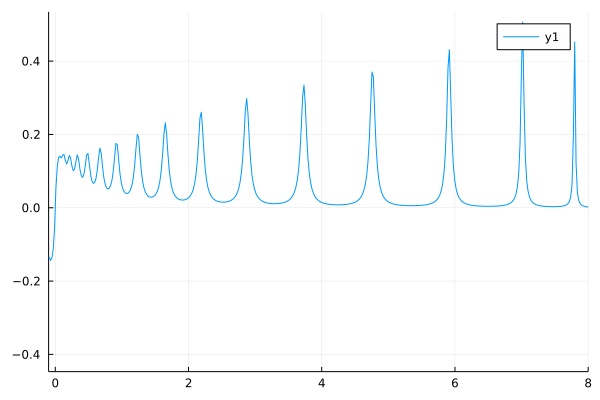

In [46]:
plot(xlim = [-0.1,8])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi))

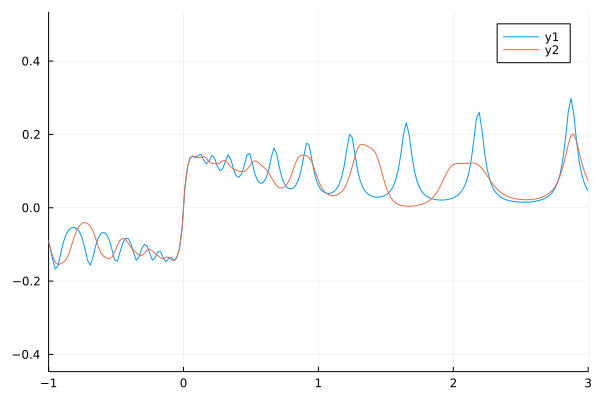

In [49]:
plot(xlim = [-1,3])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)))

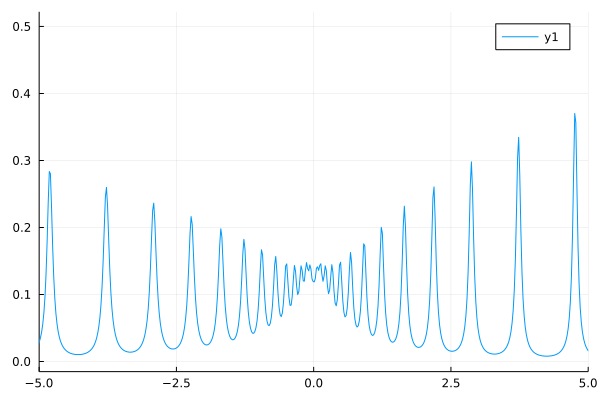

In [51]:
plot(xlim = [-5,5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi))
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)))

In [30]:
ComplexF64.(raw_reals.freq)

1000-element Vector{ComplexF64}:
             -10.0 + 0.001im
 -9.97997997997998 + 0.001im
 -9.95995995995996 + 0.001im
 -9.93993993993994 + 0.001im
 -9.91991991991992 + 0.001im
  -9.8998998998999 + 0.001im
 -9.87987987987988 + 0.001im
 -9.85985985985986 + 0.001im
 -9.83983983983984 + 0.001im
 -9.81981981981982 + 0.001im
  -9.7997997997998 + 0.001im
 -9.77977977977978 + 0.001im
 -9.75975975975976 + 0.001im
                   ⋮
  9.77977977977978 + 0.001im
   9.7997997997998 + 0.001im
  9.81981981981982 + 0.001im
  9.83983983983984 + 0.001im
  9.85985985985986 + 0.001im
  9.87987987987988 + 0.001im
   9.8998998998999 + 0.001im
  9.91991991991992 + 0.001im
  9.93993993993994 + 0.001im
  9.95995995995996 + 0.001im
  9.97997997997998 + 0.001im
              10.0 + 0.001im

In [53]:
function exact_suscep(qx, qy, omega, nsize, beta, hami)
    chi = zeros(ComplexF64, length(omega))
    for iomega in 1:length(omega)
        for ix in 1:nsize, iy in 1:nsize
            kx::Float64 = 2*(ix-1)/nsize
            ky::Float64 = 2*(iy-1)/nsize
            ek  = hami(kx,ky)
            ekq = hami(kx-qx,ky-qy)
            chi[iomega] += -(IRFLEX.fermi_dirac(ekq,beta)-IRFLEX.fermi_dirac(ek,beta))/(omega[iomega]+ekq-ek)
        end
        chi[iomega] = chi[iomega]/(nsize*nsize)
    end
    return chi
end

exact_suscep (generic function with 1 method)

In [54]:
exa_chi = exact_suscep(π,π,ComplexF64.(raw_reals.freq),nsize,SparseIR.β(basis),hami)
;

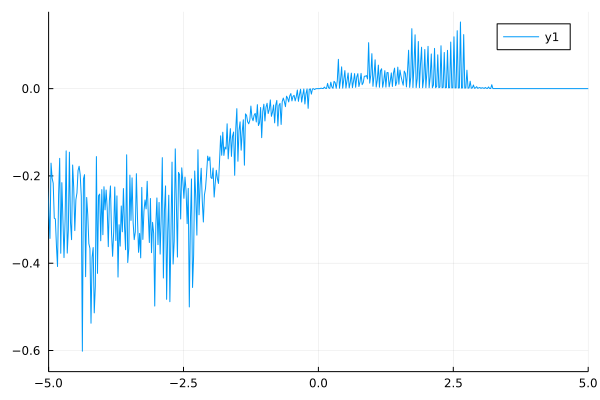

In [41]:
plot(xlim = [-5,5])
plot!(real.(raw_reals.freq), imag.(exa_chi))